In [4]:
import pickle
import argparse
import asyncio
import json
import os
import time
import json
import requests
from collections import defaultdict
from urllib.error import HTTPError
from urllib.parse import quote_plus
from Bio import Entrez
import pandas as pd
import json

from openai import OpenAI, AsyncOpenAI


In [5]:
with open("/Users/yiquntchen/Downloads/test-4o-full-test-double-negated-dataset.jsonl", "r") as f:
    question_data = [json.loads(line) for line in f]

In [6]:
question_data[0]

{'doi': '10.1002/14651858.CD009848.PUB2',
 'question': 'Do exercise interventions decrease fear of falling immediately after the intervention in older people living in the community?',
 'answer': 'Yes',
 'original_question': 'Do exercise interventions increase fear of falling immediately after the intervention in older people living in the community?',
 'original_answer': 'No',
 'evidence-quality': 'Low',
 'discrepancy': 'No',
 'negation-valid': True}

In [7]:
import pickle

with open("/Users/yiquntchen/Downloads/gpt4o-temp-results-one-netry.pkl", 'rb') as f:
    gpt4o_result = pickle.load(f)

In [9]:
json_path = "/Users/yiquntchen/Downloads/test_4o_mini_on_4o_DOUBLE_negative_prompts_benchmark.json"  # Replace with desired output path
with open(json_path, 'rb') as f:
    result_4o_mini_on_4o_Q = json.load(f)

In [10]:
json_path = "/Users/yiquntchen/Downloads/clean_pubmed_abstract_data_no_protocol.pkl"  # Replace with desired output path
with open(json_path, 'rb') as f:
    clean_pubmed_abstract_data_no_protocol = pickle.load(f)

In [18]:
clean_pubmed_abstract_data_no_protocol

{'10.1002/14651858.CD008285': {'pubmed_id': '20091664',
  'title': 'Reducing uncertainties about the effects of chemoradiotherapy for cervical cancer: individual patient data meta-analysis.',
  'abstract': "After a 1999 National Cancer Institute (NCI) clinical alert was issued, chemoradiotherapy has become widely used in treating women with cervical cancer. Two subsequent systematic reviews found that interpretation of the benefits was complicated and some important clinical questions were unanswered. We initiated a meta-analysis seeking updated individual patient data (IPD) from all randomised controlled trials (RCTs) to assess the effect of chemoradiotherapy on all outcomes. We pre-specified analyses to investigate whether the effect of chemoradiotherapy differed by trial or patient characteristics. We supplemented MEDLINE, LILACS and CANCERLIT searches with information from trial registers, by handsearching relevant meeting proceedings and by discussion with relevant trialists and o

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Sample data (replace or extend with your actual responses)
data = result_4o_mini_on_4o_Q

# Convert the dictionary to a DataFrame
df = pd.DataFrame.from_dict(data, orient="index")
df.index.name = "qid"
df.reset_index(inplace=True)

df["answer_match"] = (
    (df["model_answer"] == df["ground_truth_answer"]) |
    (
        (df["model_answer"] == "Not Enough Evidence") &
        (df["ground_truth_answer"] == "No Evidence")
    )
)
df["discrepancy_match"] = df["model_discrepancy"] == df["ground_truth_discrepancy"]
df["evidence_quality_match"] = df["model_evidence-quality"] == df["ground_truth_evidence-quality"]

# ---------------------------
# 1. Summary Tables
# ---------------------------

# Overall accuracy summary
summary_table = pd.DataFrame({
    "Metric": ["Answer Accuracy", "Discrepancy Accuracy", "Evidence Quality Accuracy"],
    "Accuracy": [
        df["answer_match"].mean(),
        df["discrepancy_match"].mean(),
        df["evidence_quality_match"].mean()
    ]
})

print("Summary Accuracy Table")
print(summary_table.to_string(index=False))
print("\n")


Summary Accuracy Table
                   Metric  Accuracy
          Answer Accuracy  0.515528
     Discrepancy Accuracy  0.658034
Evidence Quality Accuracy  0.330950




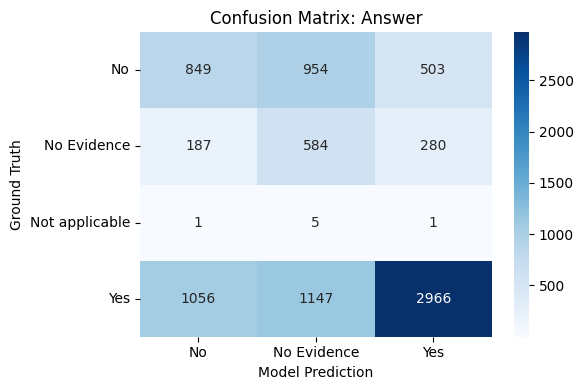

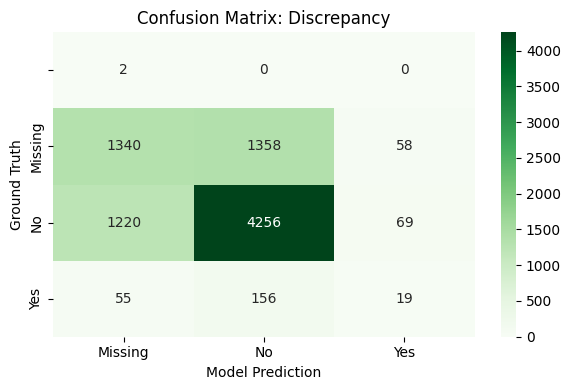

In [12]:

# ---------------------------
# 2. Confusion Matrices
# ---------------------------

# Confusion matrix for the answer field
answer_cm = pd.crosstab(df["ground_truth_answer"], df["model_answer"], rownames=['Ground Truth'], colnames=['Model Prediction'])
plt.figure(figsize=(6, 4))
sns.heatmap(answer_cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix: Answer")
plt.tight_layout()
plt.show()

# Confusion matrix for the discrepancy field
discrepancy_cm = pd.crosstab(df["ground_truth_discrepancy"], df["model_discrepancy"], rownames=['Ground Truth'], colnames=['Model Prediction'])
plt.figure(figsize=(6, 4))
sns.heatmap(discrepancy_cm, annot=True, fmt="d", cmap="Greens")
plt.title("Confusion Matrix: Discrepancy")
plt.tight_layout()
plt.show()


In [13]:

# ---------------------------
# 3. Classification Reports
# ---------------------------

# Classification report for answer
report_answer = classification_report(df["ground_truth_answer"], df["model_answer"], output_dict=True)
report_answer_df = pd.DataFrame(report_answer).transpose()
print("Classification Report: Answer")
print(report_answer_df.to_string())
print("\n")

# Classification report for discrepancy
report_discrepancy = classification_report(df["ground_truth_discrepancy"], df["model_discrepancy"], output_dict=True)
report_discrepancy_df = pd.DataFrame(report_discrepancy).transpose()
print("Classification Report: Discrepancy")
print(report_discrepancy_df.to_string())
print("\n")


/Users/yiquntchen/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/yiquntchen/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/yiquntchen/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

Classification Report: Answer
                precision    recall  f1-score      support
No               0.405638  0.368170  0.385997  2306.000000
No Evidence      0.217100  0.555661  0.312216  1051.000000
Not applicable   0.000000  0.000000  0.000000     7.000000
Yes              0.790933  0.573805  0.665097  5169.000000
accuracy         0.515528  0.515528  0.515528     0.515528
macro avg        0.353418  0.374409  0.340827  8533.000000
weighted avg     0.615482  0.515528  0.545662  8533.000000


Classification Report: Discrepancy
              precision    recall  f1-score      support
               0.000000  0.000000  0.000000     2.000000
Missing        0.512037  0.486212  0.498790  2756.000000
No             0.737608  0.767538  0.752276  5545.000000
Yes            0.130137  0.082609  0.101064   230.000000
accuracy       0.658034  0.658034  0.658034     0.658034
macro avg      0.344945  0.334090  0.338032  8533.000000
weighted avg   0.648206  0.658034  0.652675  8533.000000




/Users/yiquntchen/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/yiquntchen/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


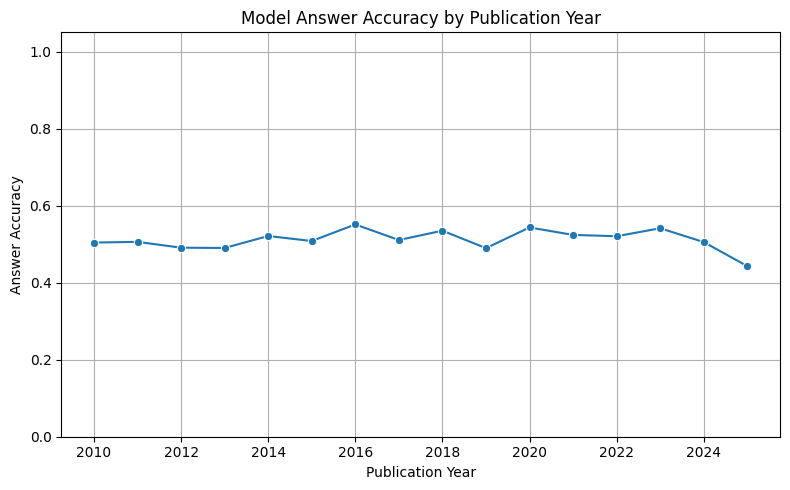

In [14]:

# ---------------------------
# 4. Extended Analysis with Metadata
# ---------------------------
# Suppose you have additional metadata (e.g., publication_year and citation_count) indexed by DOI.
# We simulate a metadata dictionary below. In practice, this may be merged on the 'doi' field.

metadata_dict = clean_pubmed_abstract_data_no_protocol

# Convert metadata to a DataFrame
meta_df = pd.DataFrame.from_dict(metadata_dict, orient="index")
meta_df.index.name = "doi"

# If the 'doi' column already exists in meta_df, drop it before resetting the index.
if "doi" in meta_df.columns:
    meta_df = meta_df.drop(columns=["doi"])

meta_df.reset_index(inplace=True)

# Convert 'publication_year' to datetime and extract the year
meta_df["publication_year"] = pd.to_datetime(meta_df["publication_year"], errors='coerce')
meta_df["pub_year"] = meta_df["publication_year"].dt.year

# Merge the metadata into the main DataFrame (which already contains a 'doi' column)
merged_df = pd.merge(df, meta_df, on="doi", how="left")

# Recalculate answer_match in case it's needed after merge
merged_df["answer_match"] = merged_df["model_answer"] == merged_df["ground_truth_answer"]

# Analyze accuracy by publication year
year_accuracy = merged_df.groupby("pub_year")["answer_match"].mean().reset_index()
year_accuracy.columns = ["Publication Year", "Answer Accuracy"]

plt.figure(figsize=(8, 5))
sns.lineplot(data=year_accuracy, x="Publication Year", y="Answer Accuracy", marker="o")
plt.title("Model Answer Accuracy by Publication Year")
plt.ylim(0, 1.05)
plt.grid(True)
plt.tight_layout()
plt.show()

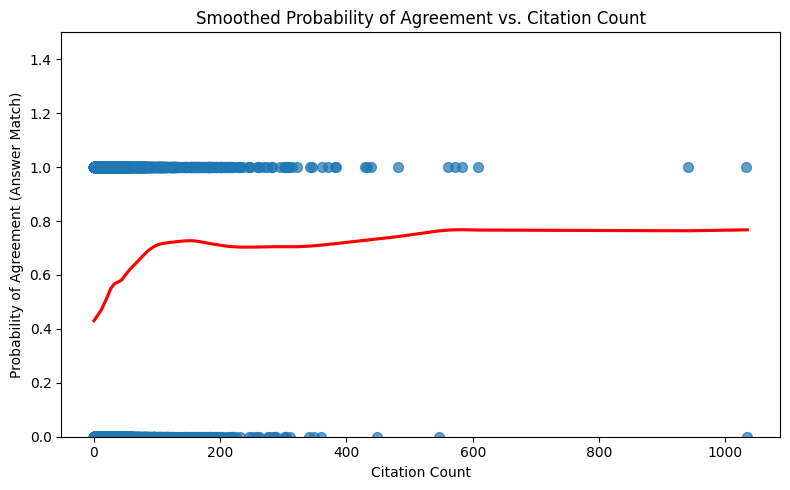

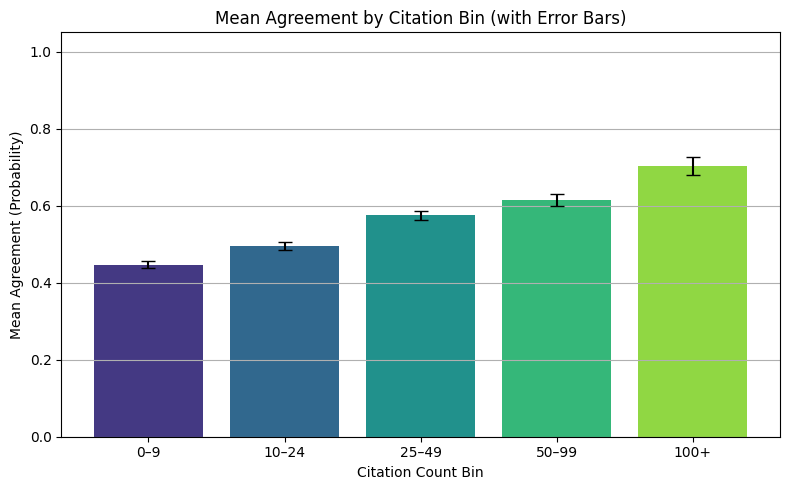

Binned Citation Accuracy with Standard Error:
citation_bin     mean      sem  count
         0–9 0.446287 0.009241   2895
       10–24 0.494911 0.009709   2653
       25–49 0.575367 0.011974   1705
       50–99 0.614499 0.016520    869
        100+ 0.702918 0.023567    377

Correlation Tests between Citation Count and Answer Agreement:
Pearson Correlation: 0.107 (p-value: 3.73e-23)
Spearman Correlation: 0.134 (p-value: 2.49e-35)


In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import pearsonr, spearmanr

# --- Assume merged_df has been created from your main DataFrame (with a doi column)
# and merged with meta_df as in previous steps. Ensure merged_df has these columns:
# 'citation_count' (numeric), 'answer_match' (boolean), and 'pub_year'

# Convert answer_match boolean to numeric (True->1, False->0)
merged_df["answer_match_numeric"] = merged_df["answer_match"].astype(int)

# -----------------------------------------------------------
# 1. Plot smoothed probability of agreement vs. citation count
# -----------------------------------------------------------
plt.figure(figsize=(8, 5))
sns.regplot(data=merged_df, x="citation_count", y="answer_match_numeric", lowess=True, 
            scatter_kws={'s':50, 'alpha':0.7}, line_kws={'color': 'red'})
plt.title("Smoothed Probability of Agreement vs. Citation Count")
plt.xlabel("Citation Count")
plt.ylabel("Probability of Agreement (Answer Match)")
plt.ylim(0, 1.5)
plt.tight_layout()
plt.show()

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define citation bins
bins = [0, 10, 25, 50, 100, np.inf]
labels = ["0–9", "10–24", "25–49", "50–99", "100+"]

# Bin citation counts
merged_df["citation_bin"] = pd.cut(
    merged_df["citation_count"],
    bins=bins,
    labels=labels,
    right=False
)

# Group by citation bin and compute mean + standard error
citation_bin_stats = merged_df.groupby("citation_bin", observed=True)["answer_match_numeric"].agg(
    mean="mean",
    count="count",
    std="std"
).reset_index()

# Compute standard error and handle empty bins gracefully
citation_bin_stats["sem"] = citation_bin_stats["std"] / np.sqrt(citation_bin_stats["count"])
citation_bin_stats["sem"] = citation_bin_stats["sem"].fillna(0)  # Replace NaN sem for empty bins

# Plot bar chart with error bars manually using matplotlib
plt.figure(figsize=(8, 5))
bars = plt.bar(
    citation_bin_stats["citation_bin"].astype(str),
    citation_bin_stats["mean"],
    yerr=citation_bin_stats["sem"],
    capsize=5,
    color=sns.color_palette("viridis", len(citation_bin_stats))
)
plt.title("Mean Agreement by Citation Bin (with Error Bars)")
plt.xlabel("Citation Count Bin")
plt.ylabel("Mean Agreement (Probability)")
plt.ylim(0, 1.05)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Print stats table
print("Binned Citation Accuracy with Standard Error:")
print(citation_bin_stats[["citation_bin", "mean", "sem", "count"]].to_string(index=False))


# -----------------------------------------------------------
# 3. Correlation Test: Citation Count vs. Accuracy
# -----------------------------------------------------------
# Ensure citation_count is numeric
merged_df["citation_count"] = pd.to_numeric(merged_df["citation_count"], errors="coerce")

# Drop any rows with missing values in citation_count or answer_match_numeric
corr_df = merged_df.dropna(subset=["citation_count", "answer_match_numeric"])

# Pearson correlation
pearson_corr, pearson_p = pearsonr(corr_df["citation_count"], corr_df["answer_match_numeric"])
# Spearman correlation
spearman_corr, spearman_p = spearmanr(corr_df["citation_count"], corr_df["answer_match_numeric"])

print("\nCorrelation Tests between Citation Count and Answer Agreement:")
print("Pearson Correlation: {:.3f} (p-value: {:.3g})".format(pearson_corr, pearson_p))
print("Spearman Correlation: {:.3f} (p-value: {:.3g})".format(spearman_corr, spearman_p))

In [16]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np 

# Prepare clean dataset
logit_df = merged_df.dropna(subset=["citation_count", "answer_match_numeric"]).copy()

# Fit logistic regression model
logit_model = smf.logit("answer_match_numeric ~ citation_count", data=logit_df).fit()

# Print model summary
print(logit_model.summary())

# Optional: Odds ratio + 95% CI
odds_ratios = pd.DataFrame({
    "OR": logit_model.params.apply(lambda x: np.exp(x)),
    "2.5%": logit_model.conf_int()[0].apply(lambda x: np.exp(x)),
    "97.5%": logit_model.conf_int()[1].apply(lambda x: np.exp(x)),
})
print("\nOdds Ratios with 95% CI:")
print(odds_ratios)

Optimization terminated successfully.
         Current function value: 0.685865
         Iterations 5
                            Logit Regression Results                            
Dep. Variable:     answer_match_numeric   No. Observations:                 8499
Model:                            Logit   Df Residuals:                     8497
Method:                             MLE   Df Model:                            1
Date:                  Tue, 22 Apr 2025   Pseudo R-squ.:                0.009779
Time:                          08:50:33   Log-Likelihood:                -5829.2
converged:                         True   LL-Null:                       -5886.7
Covariance Type:              nonrobust   LLR p-value:                 7.351e-27
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.1081      0.028     -3.917      0.000      -0.162      -0.054
c